# Business Understanding
This year, I have started working for the Scottish Government, within the AI & Data Science unit. I am therefore looking to enhance my skills as a Data Scientist, to aid in implementing solutions that could help government make the fastest, best, and fairest decisions.

I have always been fascinated by crime, and I know I am not alone. The growing popularity of crime shows means big business and not just for streaming services — yes, I am looking at you, Netflix.

Beyond personal curiosity, crime statistics serve as a vital tool for shaping government policies. These statistics provide invaluable insights into the frequency and distribution of criminal activities, offering a compass for policymakers to navigate the complexities of law enforcement.

By understanding such patterns, authorities can strategically allocate resources, optimizing the deployment of police presence in areas with higher crime rates. Moreover, a nuanced analysis of crime statistics proves instrumental in identifying and addressing emerging crime problems, fostering a proactive and adaptable approach to maintaining public safety.

In here, I have analysed the “Recorded Crimes and Offences” dataset, which contains statistics on crimes and offences, including number of crimes/offences and crime/offence rates per 10,000 population recorded by Police Scotland from 1996/97 to 2022/23 and by Local Authority. I have decided to focus on three simple exploratory questions for my first project:

1. How have reported crime rates changed over time in Scotland?
2. In the past year, which countries show the highest increase and decrease in overall crime rates?
3. Which Scottish counties have more similar crime patterns?

# The dataset
The Scottish Government has made over 250 datasets from a range of producers publicly available at statistics.gov.scot. It is a great resource, and here I have focused on the “Recorded Crimes and Offences” dataset.

This dataset contains statistics on crimes and offences, including number of crimes/offences and crime/offence rates per 10,000 population recorded by Police Scotland from 1996/97 to 2022/23 and by Local Authority. I have decided to focus on three simple exploratory questions for my first project.

# Importing, cleaning and preparing data

In [1]:
# to handle datasets
import pandas as pd
import json
# to make plots
import plotly.express as px
from urllib.request import urlopen
# importing helper functions
import helper_functions as hlp
# Modelling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# First read dataset
# Reading crime rates statistics
# Downloaded from "https://statistics.gov.scot/downloads/cube-table?uri=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Frecorded-crime"
crimes_df = pd.read_csv("assets/data/scottish_crime_rates.csv")

In [3]:
# Creating cleaner data frame with crimes with only ratios (not counts) for counties.
# Crime types and date columns have been transformed to ordered categorical type
# Each row contains a unique crime ratio for each county, date and crime type
parsed_data = hlp.parse_df(crimes_df) # This function returns a list with a df and another list
# Pivoting table here so we can have crime types as columns for plotting
crimes_ratios_df = parsed_data[0]
pivoted_crimes_ratios_df = pd.pivot_table(crimes_ratios_df, values="Value", index=["Date","LAD"], columns="Crime").reset_index("LAD")

In [4]:
# This data has probably been pre-processed, so there are no missing values.
crimes_ratios_df.isnull().sum()

LAD Code       0
LAD            0
FeatureType    0
Date           0
Measurement    0
Units          0
Value          0
Crime          0
dtype: int64

# Visualizing & Modelling the dataset
## Question 1: How do Scottish Crime rates vary over time?


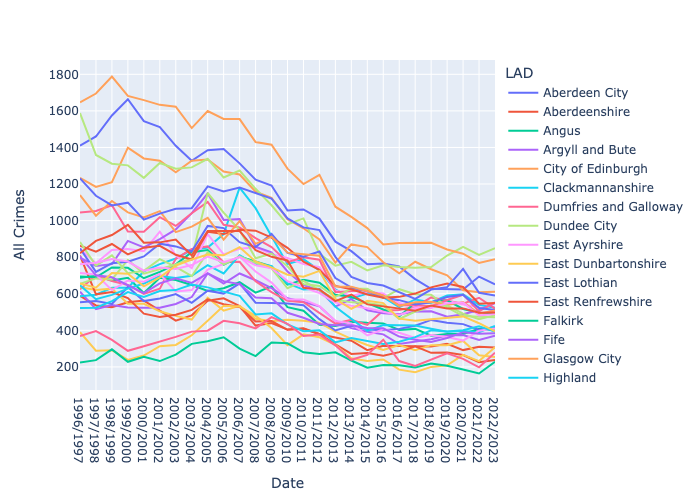

In [5]:
# Plotting overall Scottish crime ratios over time
fig = px.line(data_frame=pivoted_crimes_ratios_df, x=pivoted_crimes_ratios_df.index, y="All Crimes", color="LAD")
fig.write_html("assets/scottish_crime_ratios_over_time.html", default_width="100%", default_height="100%")
fig.show("png") # otherwise notebook gets too large...

If we focus on the year 1996/1997 (left-most side of the figure), there are a couple of counties that stand out for having a lot more reported crimes than the rest. Here’s the top-three:

- Glasgow is first (with a staggering 1647 crimes reported for every 10,000 people) 🥇
- Dundee comes in a close second 🥈
- Aberdeen comes in third 🥉

Although I am not sure this is a race you would really want to win…

The bottom-three are all Scottish isles: Orkney, Shetland and Na h-Eileanan an Iar (the Outer-Hebrides).

In conclusion, if I were more risk-averse and had to decide where I would relocate within Scotland, I would be tempted to embrace the island lifestyle! Nonetheless, if we follow the lines from the past to the end of 2022 (or left to right), we can see the trend across all counties looks good: crime rates seem to be going down in Scotland!

## Question 2: Which counties show highest increase and decrease in crime rates, over the past two years?


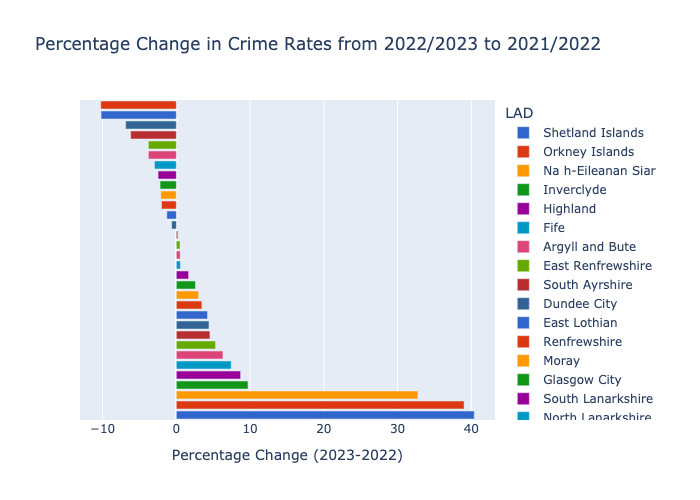

In [6]:
# Here I will select all crimes and calculate percentage changes between the last two years, for each county
all_crimes_df = crimes_ratios_df[crimes_ratios_df["Crime"]=="All Crimes"]
all_crimes_pivoted_df = pd.pivot_table(all_crimes_df, values="Value", index=["LAD"], columns="Date")
all_crimes_pivoted_df["Percentage Change (2023-2022)"] = ((all_crimes_pivoted_df["2022/2023"] - all_crimes_pivoted_df["2021/2022"])  / all_crimes_pivoted_df["2021/2022"] ) * 100

# Here I am plotting the bar graph of percentage changes
fig = px.bar(data_frame=all_crimes_pivoted_df.sort_values("Percentage Change (2023-2022)", ascending=False).reset_index(),
             x="Percentage Change (2023-2022)", color="LAD",
             color_discrete_sequence=px.colors.qualitative.G10,
             title="Percentage Change in Crime Rates from 2022/2023 to 2021/2022")
fig.update_yaxes(visible=False)
fig.write_html("assets/percent_change_crimes.html", default_width="100%", default_height="100%")
fig.show("png")

The three counties showing highest increase in crime rates in the past years are the three isles: Shetlands (40%), Orkney (39%) and Na h-Eileanan an Iar (33%). This would’ve been hard to conclude just by visually inspecting the first figure!

However, it is important to note this is a cross-sectional comparison, meaning it is only a snapshot of a point in time. Just because crime rates increased in the isles, does not mean they are expected to keep increasing over time.

## Question 3: Can we cluster counties by crime rate similarity?

Looking at overall crime rates gives us a broad perspective of crime trends in Scotland. However, I would also like to understand if we can find similarity patterns between counties, by looking at the different crime types.

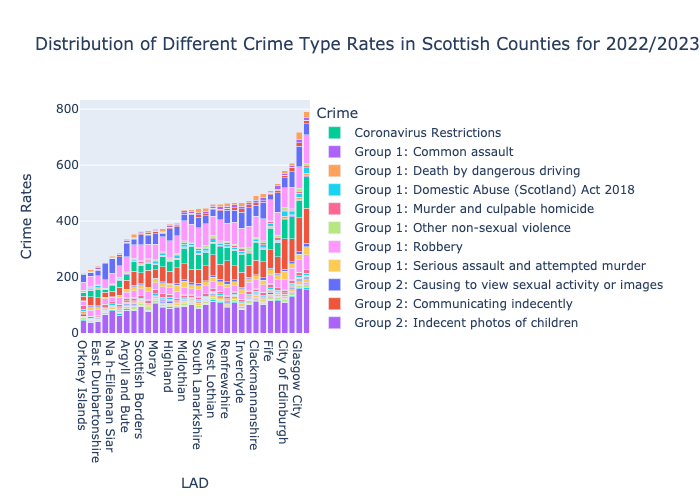

In [7]:
# Stacked Bar Plot
crime_subtypes = crimes_ratios_df[~crimes_ratios_df["Crime"].str.contains('Crimes')]

crime_subtypes_filtered = crime_subtypes[crime_subtypes["Date"]=="2022/2023"]
crime_subtypes_filtered.loc[:,"Crime"] = crime_subtypes_filtered.Crime.cat.remove_unused_categories()
ordered_crimes = parsed_data[1][1:]


fig = px.bar(crime_subtypes_filtered, x="LAD",y="Value", color="Crime", 
            title="Distribution of Different Crime Type Rates in Scottish Counties for 2022/2023",
            category_orders={"Crime": ordered_crimes},
            labels={"Value":"Crime Rates"}, 
            barmode="stack")

fig.update_xaxes(categoryorder="total ascending")
fig.write_html("assets/different_crime_types_2022-2023.html", default_width="100%", default_height="100%")
fig.show("png")

If we compare the total value of crime rates and the proportions of different crime types between each county, we can see that some counties seem to have more similar patterns to one another. For example, Glasgow and Edinburgh are more similar to each other and the Orkney Islands are more similar to East Dunbartonshire.

To assess this more formally, we can make use of mathematical algorithms. More specifically, I will make use of the k-Means Clustering algorithm.  K-means clustering is a distance-based unsupervised clustering algorithm where data points that are close to each other are gruped in a given number of clusters/groups.

For K-mean clustering, I need to define the initial number of clusters. The elbow method involves finding the optimal k via a graphical representation. It works by finding the  within-cluster sum of square (WCSS), i.e. the sum of the square distance between points in a cluster and the cluster centroid.

In [8]:
# Cluster Analysis to group similar counties based on Crime Type Ratios
# First I am checking which crime types have values all equal to zero and filter them
zero_values = list()
for crime in ordered_crimes:
    if crime_subtypes_filtered[crime_subtypes_filtered["Crime"]==crime].Value.sum() == 0:
        zero_values.append(crime)


features = crime_subtypes_filtered[~crime_subtypes_filtered["Crime"].isin(zero_values)]
features = features.pivot_table(index=["LAD"], columns="Crime", values="Value").reset_index()
X = features.drop(["LAD"], axis=1)
# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

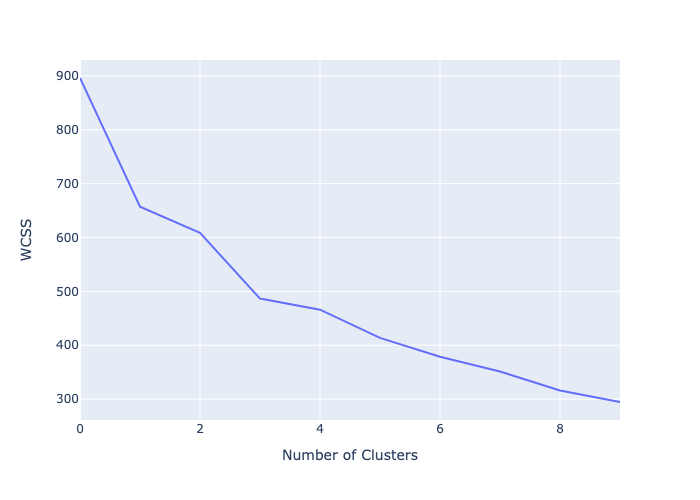

In [9]:
# Plotting WCSS vs number of clusters (Elbow method)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init="auto")
    kmeans.fit(X_standardized)
    wcss.append(kmeans.inertia_)

fig = px.line(wcss)
fig.update_layout(
    xaxis_title="Number of Clusters", yaxis_title="WCSS",
    showlegend=False
)
fig.show("png")

From the plot above, we will consider 4 as the optimal number of clusters (k).

In [10]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_standardized)
clusters +=1

# Add cluster labels to the dataframe
features['Cluster'] = clusters
features.loc[:,"Cluster"] = pd.Categorical(features["Cluster"], ordered=True)

Below I am plotting the cluster to which the county belongs to on a map, for better visualization.

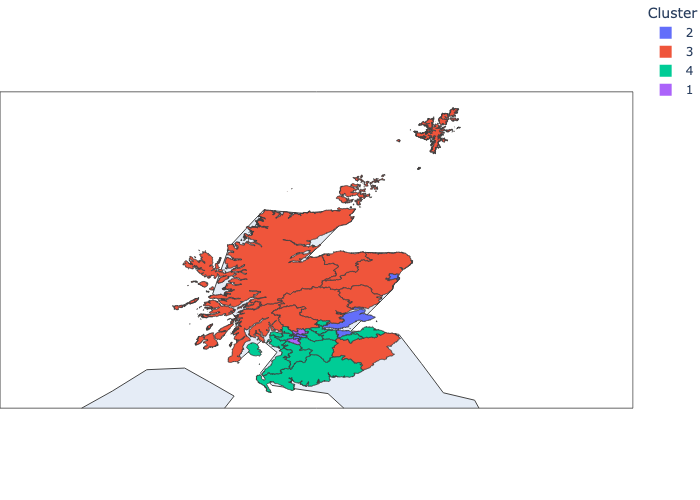

In [11]:
# Plotting clusters on Scottish Map
with urlopen('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/administrative/sco/lad.json') as response:
    counties = json.load(response)

fig = px.choropleth(features,  geojson=counties, color='Cluster', locations="LAD",
                           featureidkey="properties.LAD13NM"
                          )
fig.update_geos(fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_html("assets/cluster_crimes_chloropeth.html", default_width="100%", default_height="100%")
fig.show("png")

We can see that:

- Cluster 1, consists of East Dunbartonshire and East Renfrewshire.
- Cluster 2, consists of Aberdeen, Dundee, Edinburgh and Glasgow.
- Cluster 3, consists of Aberdeenshire, Angus, Argyll and Bute, Highland, Moray, Na h-Eileanan Siar, Orkney Islands, Perth and Kinross, Scottish Borders, Shetland Islands and Stirling.
- Cluster 4, consists of Clackmannanshire Dumfries and Galloway, East Ayrshire, East Lothian, Falkirk, Inverclyde, Midlothian, North Ayrshire, North Lanarkshire, Renfrewshire, South Ayrshire, South Lanarkshire, West Dunbartonshire and West Lothian.

To check what the different clusters are capturing, I have calculated the mean crime rates for each crime type in each cluster:

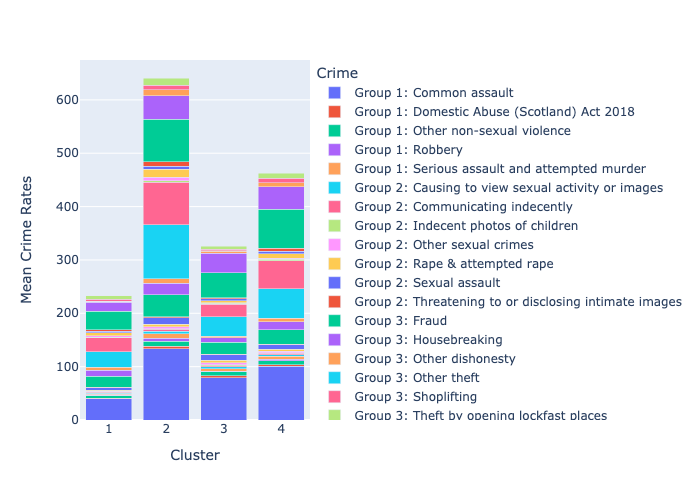

In [12]:
# Calculate cluster mean crime rates and plot distributions to check
# what the different clusters are capturing
kmeans_mean_cluster = features.drop(columns=["LAD"]).groupby("Cluster").mean()
fig = px.bar(kmeans_mean_cluster, barmode="stack")
fig.update_layout(
    xaxis_title="Cluster", yaxis_title="Mean Crime Rates",
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1, 2, 3, 4],
        ticktext = ['1', '2', '3', '4']
    ))
fig.write_html("assets/cluster_means_2022-2023.html", default_width="100%", default_height="100%")
fig.show("png")

We can clearly see, that Cluster 1 (East Dunbartonshire and East Renfrewshire) has lower mean crime rates compared to the other clusters, and we can observe the exact opposite for cluster number 2. 

The separation between clusters is also visible if we plot crime rates for "Common assault" and "Vandalism", for example. In this case, these two crime types seem to vary linearly, that is, a county with high vandalism rates will also likely have high common assault rates:

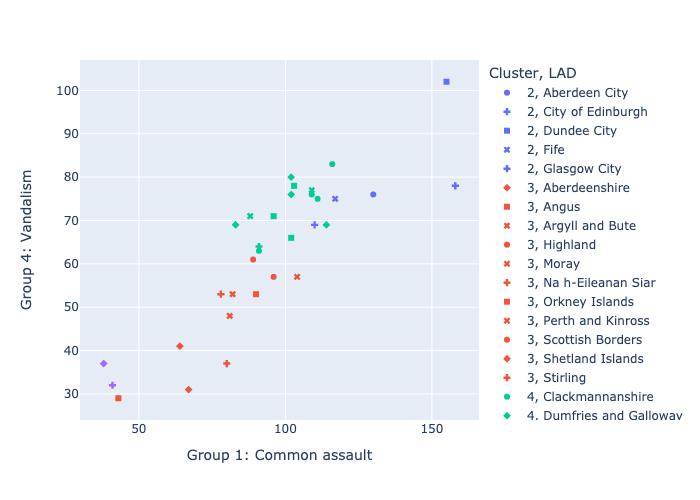

In [13]:
# Let's plot Common Assault vs Vandalism
fig = px.scatter(features, x="Group 1: Common assault", y="Group 4: Vandalism", color="Cluster", symbol="LAD")
fig.write_html("assets/vandalism_vs_assault_clusters_2022-2023.html", default_width="100%", default_height="100%")
fig.show("png")

Interestingly, this separation becomes murkier if we plot crime rates for "Common assault" and "Drugs Possession". In this case, the linearity of their relationship is not so clear. For example, if we hover over the Shetland Islands, we can see they show high rates for drug possession, but relatively lower rates for common assault:

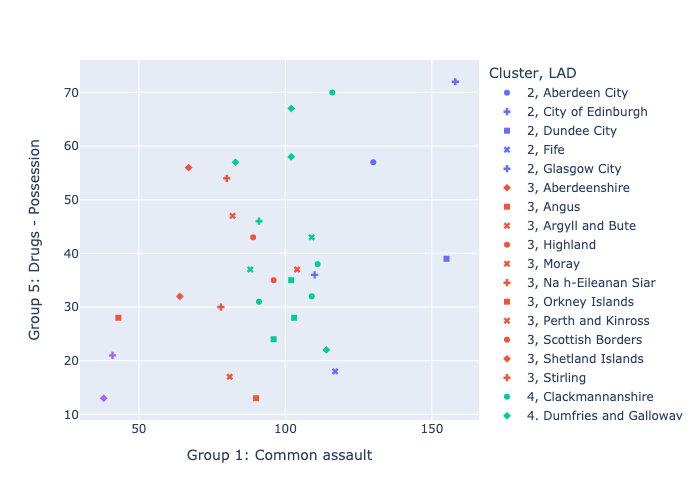

In [14]:
# Let's plot Common Assault vs Drug Possession
fig = px.scatter(features, x="Group 1: Common assault", y="Group 5: Drugs - Possession", color="Cluster", symbol="LAD")
fig.write_html("assets/drugs_possession_vs_assault_clusters_2022-2023.html", default_width="100%", default_height="100%")
fig.show("png")

It makes me wonder...

What is going in Shetland?

# Conclusions

- Overall crime rates seem to be going down in Scotland.
- Some areas with lower crime rates have shown an increase in overall crime rates last year (e.g., Orkney, Shetlands and Outer-Hebrides).
- We can cluster Scottish counties into 4-different groups taking into account different crime type rates. From lower to higher mean crime rates: Cluster 1 < Cluster 3 < Cluster 4 < Cluster 2.

## Limitations

There are several limitations to these analyses, including:

- The high-dimensionality of the data: As the number of dimensions increases, a distance-based similarity measure converges to a constant value between any given examples. I could've potentially addressed this by using a dimensionality reduction technique (such as principal component analysis).
- The random initialization of k being dependent on the initial values.
- Highly impacted by outliers.
- Always tried to find circular clusters.

## Some possible follow-up questions

- Can we predict specific crime types for each county?
- Why aren't the isles clustered within cluster 1?
- Why do some counties show high crime rate levels of one type of crime, but not others (e.g., Shetlands have high drugs possession crime rates, but overall low crime)?
- Can we reduce dimensionality of data before clustering?
- Is there a better algorithm other than K-means to capture non-spherical clusters?
- Even though crime rates are calculated per capita, what is the effect of different population densities in each county?